### Imports

In [33]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy 
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker
import xesmf as xe
import matplotlib.colors as colors

### Functions

In [54]:
def regrid(var, lat_step=0.1, lon_step=0.1):
    # Create new lons and lats on a regular grid
    new_lat=np.arange(-90,90.1,lat_step)
    new_lon=np.arange(0,360.1,lon_step)

    # Create an xarray.Dataset that defines the new grid
    ds_out = xr.Dataset({'lat': (['lat'], new_lat),
                    'lon': (['lon'], new_lon)})
    
    # Regrid the data to the new grid 
    regridder = xe.Regridder(ds, ds_out, 'bilinear', reuse_weights=True)
    dr = regridder(ds[var]).to_dataset(name=var)
    
    return dr

### Load ASRv2 2001 January Monthly 2D Analysis

In [53]:
file = '/shared/scratch/jgaigala/asr15km.anl.2D.200001.mon.nc'

In [49]:
ds = xr.open_dataset(file)
ds = ds.rename({'XLONG': 'lon', 'XLAT': 'lat'})
dr = regrid('SH2O').squeeze()
dr

### Map 'SH20' (Soil Liquid Water) at 4 depth levels

Text(0.5, 0.98, 'ARSv2 2000 January Soil Liquid Water')

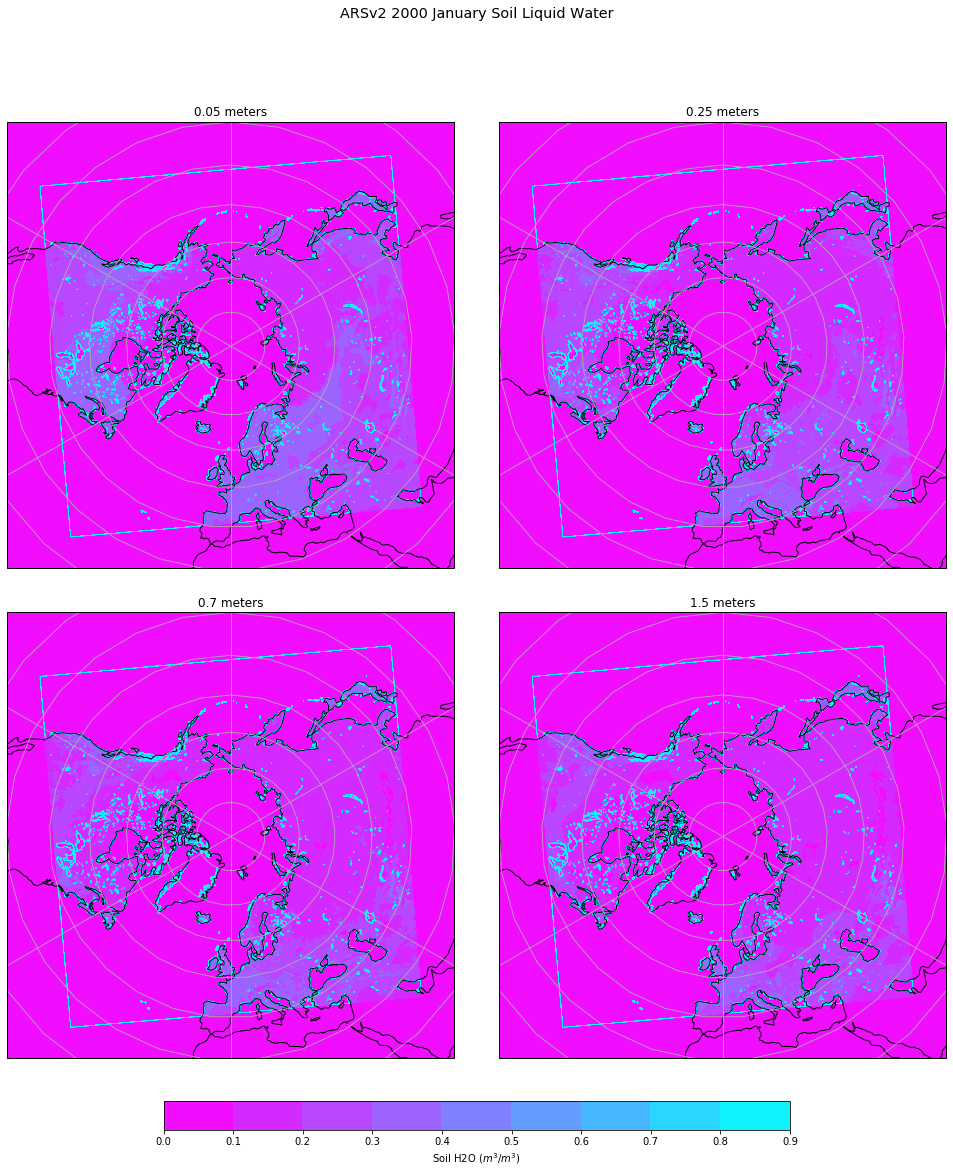

In [59]:
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.NorthPolarStereo()},
                        figsize=(14.5,20))
axs=axs.flatten()

clevs=np.arange(0.0,1.0, 0.1)

for lev, depth in [(4.0,0.05), (3.0,0.25), (2.0,0.7), (1.0, 1.5)]:
    ax = axs[int(4-lev)]
    
    cs=ax.contourf(dr['lon'], dr['lat'], 
            dr['SH2O'].sel(lev=lev), clevs,
            transform=ccrs.PlateCarree(),
            cmap='cool_r')
    ax.set_extent([-180, 180, 30, 90], ccrs.PlateCarree())

    # add reference lines
    ax.coastlines()
    ax.gridlines()
    
    ax.set_title(f"{depth} meters")

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.1)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='Soil H2O $(m^3/m^3)$')

# Add a big title at the top
plt.suptitle('ARSv2 2000 January Soil Liquid Water', size='x-large')